In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from pref.utility.Additive_Utility_Model import *
import numpy as np
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from feature_selection.evaluation.Classification_Evaluation import Classification_Evaluator
from feature_selection.wrapper_fishburn import Wrapper_Fishburn
from feature_selection.wrapper_local_search import Wrapper_Local_Search
from feature_selection.wrapper_stochastic_local_search import Wrapper_Stochastic_Local_Search
from feature_selection.wrapper_model import Wrapper_Model
from feature_selection.wrapper_nsga2 import Wrapper_NSGA2
from pref.utility.Preferences import sampleSubset

# Utilisation d'une approche ordinale pour la sélection d'attributs

Ce notebook contient une démonstration du code qui a été développé jusque ici, une explication du framework utilisé pour faire de la sélection d'attributs (avec pseudo-code) et enfin une étude expérimentale comparative de plusieurs approches de sélection d'attributs.

## Module de manipulation d'utilité additive

Le premier module développé sert à construire et a ajuster un modèle d'utilité additive sur des préférences.

In [2]:
n_items = 5
k = 1
items, R = sampler2(n_items, max_subsets=20) #Permet de tirer une relation en tirant un ordre aléatoire sur 20 
                                             #sous-ensembles
R[0:10] # [((1,) , (3,))] signifie que 1 est préféré a 3.

[((1, 2, 4), (0,)),
 ((1, 2, 4), (1, 2)),
 ((1, 2, 4), (2, 4)),
 ((1, 2, 4), (1, 3)),
 ((1, 2, 4), (0, 1)),
 ((1, 2, 4), (0, 1, 3)),
 ((1, 2, 4), (0, 3)),
 ((1, 2, 4), (1,)),
 ((1, 2, 4), (1, 4)),
 ((1, 2, 4), (0, 3, 4))]

On instancie le modèle comme suit

In [3]:
m = Additive_Utility_Model(items)

On peut fixer les paramètres soi-même

In [4]:
m.theta = [(1, ), (2, ), (3, )]
m.theta

[(1,), (2,), (3,)]

ou les générer de façon a avoir une fonction k-additive

In [5]:
m.create_params(1)
m.theta

{(0,): docplex.mp.Var(type=C,name='u_0',lb=-1e+20),
 (1,): docplex.mp.Var(type=C,name='u_1',lb=-1e+20),
 (2,): docplex.mp.Var(type=C,name='u_2',lb=-1e+20),
 (3,): docplex.mp.Var(type=C,name='u_3',lb=-1e+20),
 (4,): docplex.mp.Var(type=C,name='u_4',lb=-1e+20)}

In [6]:
m.create_params(2)
m.theta

{(0,): docplex.mp.Var(type=C,name='u_0',lb=-1e+20),
 (1,): docplex.mp.Var(type=C,name='u_1',lb=-1e+20),
 (2,): docplex.mp.Var(type=C,name='u_2',lb=-1e+20),
 (3,): docplex.mp.Var(type=C,name='u_3',lb=-1e+20),
 (4,): docplex.mp.Var(type=C,name='u_4',lb=-1e+20),
 (0, 1): docplex.mp.Var(type=C,name='u_0_1',lb=-1e+20),
 (0, 2): docplex.mp.Var(type=C,name='u_0_2',lb=-1e+20),
 (0, 3): docplex.mp.Var(type=C,name='u_0_3',lb=-1e+20),
 (0, 4): docplex.mp.Var(type=C,name='u_0_4',lb=-1e+20),
 (1, 2): docplex.mp.Var(type=C,name='u_1_2',lb=-1e+20),
 (1, 3): docplex.mp.Var(type=C,name='u_1_3',lb=-1e+20),
 (1, 4): docplex.mp.Var(type=C,name='u_1_4',lb=-1e+20),
 (2, 3): docplex.mp.Var(type=C,name='u_2_3',lb=-1e+20),
 (2, 4): docplex.mp.Var(type=C,name='u_2_4',lb=-1e+20),
 (3, 4): docplex.mp.Var(type=C,name='u_3_4',lb=-1e+20)}

Chaque modèle pose des bornes sur les utilités qu'on peut modifier

In [7]:
m.utility_lb = -1
m.utility_ub = +1

On peut ajouter les contraintes une a une

In [8]:
m.add_strict_preference(*R[0])

Ou en ajouter plusieurs a la fois:

In [9]:
m.create_polyhedron(R[1:])

Chaque préférence stricte conduit a créer des variables d'écarts epsilon dont la borne inférieur est supérieur a 1e-4.

On peut ensuite créer des objectifs génériques : 
- MDVF (Most Discriminant Value Function): Maximise la somme des epsilons pour avoir la fonction qui creuse le plus les préférences strictes.
- MV (Maximum Value): Maximise la somme des utilités des sous-ensembles évalués
- SE (Simplest Explication): Minimise la somme des $\theta$ pour obtenir une fonction qui utilise le moins de paramètres possible.

In [10]:
m.build_objectifs()
m.objectifs

{'MV': (docplex.mp.LinearExpr(5u_0+7u_1+3u_2+4u_3+4u_4+2u_0_1+3u_0_3+u_0_4+2u_1_2+2u_1_3+2u_1_4+2u_2_4+u_3_4),
  1),
 'MDVF': (docplex.mp.LinearExpr(p_124_0+p_124_12+p_124_24+p_124_13+p_124_01+p_124_013+p_124_03+p_124_1+p_124_14+p_124_034+p_0_12+p_0_24+p_0_13+p_0_01+p_0_013+p_0_03+p_0_1+p_0_14+p_0_034+p_12_24+p_12_13+p_12_01+p_12_013+p_12_03+p_12_1+p_12_14+p_12_034+p_24_13+p_24_01+p_24_013+p_24_03+p_24_1+p_24_14+p_24_034+p_13_01+p_13_013+p_13_03+p_13_1+p_13_14+p_13_034+p_01_013+p_01_03+p_01_1+p_01_14+p_01_034+p_013_03+p_013_1+p_013_14+p_013_034+p_03_1+p_03_14+p_03_034+p_1_14+p_1_034+p_14_034),
  1),
 'SE': (docplex.mp.LinearExpr(_abs70+_abs73+_abs76+_abs79+_abs82+_abs85+_abs88+_abs91+_abs94+_abs97+_abs100+_abs103+_abs106+_abs109+_abs112),
  -1)}

On peut également créer son propre objectif, et on est souvent amener a le faire si on veut évaluer la valeur maximale que pourrait atteindre un sous-ensemble, pour se faire on récupére l'expression qui représente l'utilité d'un sous-ensemble.

In [11]:
m.get_utility_exp((1,2))

docplex.mp.LinearExpr(u_1+u_2+u_1_2)

et on l'ajoute comme objectif

In [12]:
m.add_objectif("U_{1,2}", m.get_utility_exp((1,2)), sense = +1) #+1 pour maximiser -1 pour minimiser
m.objectifs

{'MV': (docplex.mp.LinearExpr(5u_0+7u_1+3u_2+4u_3+4u_4+2u_0_1+3u_0_3+u_0_4+2u_1_2+2u_1_3+2u_1_4+2u_2_4+u_3_4),
  1),
 'MDVF': (docplex.mp.LinearExpr(p_124_0+p_124_12+p_124_24+p_124_13+p_124_01+p_124_013+p_124_03+p_124_1+p_124_14+p_124_034+p_0_12+p_0_24+p_0_13+p_0_01+p_0_013+p_0_03+p_0_1+p_0_14+p_0_034+p_12_24+p_12_13+p_12_01+p_12_013+p_12_03+p_12_1+p_12_14+p_12_034+p_24_13+p_24_01+p_24_013+p_24_03+p_24_1+p_24_14+p_24_034+p_13_01+p_13_013+p_13_03+p_13_1+p_13_14+p_13_034+p_01_013+p_01_03+p_01_1+p_01_14+p_01_034+p_013_03+p_013_1+p_013_14+p_013_034+p_03_1+p_03_14+p_03_034+p_1_14+p_1_034+p_14_034),
  1),
 'SE': (docplex.mp.LinearExpr(_abs70+_abs73+_abs76+_abs79+_abs82+_abs85+_abs88+_abs91+_abs94+_abs97+_abs100+_abs103+_abs106+_abs109+_abs112),
  -1),
 'U_{1,2}': (docplex.mp.LinearExpr(u_1+u_2+u_1_2), 1)}

Ensuite on peut optimiser sur un objectif

In [13]:
m.optimize("MV")

Ou sur plusieurs dans l'ordre lexicographique.

In [14]:
m.optimize_lex(["MDVF", "SE"])

On peut ensuite accéder aux paramètres

In [15]:
m.get_params_values()

{'u_0': 0.9999900000000002,
 'u_1': -0.999980000000001,
 'u_2': 0.9999500000000001,
 'u_3': 0.9999499999999775,
 'u_4': -1e-05,
 'u_0_3': -2.9999099999999785,
 'u_0_4': -1.999999999946489e-05,
 'u_1_2': 1.000010000000001,
 'u_1_3': 0.9999900000000009,
 'u_2_4': 2.999999999997449e-05}

Ou calculer l'utilité de n'importe quel sous-ensemble.

In [16]:
m.get_utility_exp((2,3)).solution_value

1.9998999999999776

On peut aussi tester l'adéquation du modèle par rapport aux préférences renseignées c'est a dire la proportion de préférences qu'il modélise (qui peut être <1 si éventuellement les préférences ne sont pas additivement représentable)

In [17]:
m.adequancy()

1.0

## Module de prototypage d'une wrapper method

Ce module permet de concevoir de manière très abstraite une wrapper méthode.
Toute wrapper methode doit dériver de la classe "Wrapper Model" dont elle peut redéfinir 4 méthodes:
- initSubset : Sert a initialiser le sous-ensemble d'attributs a tester.
- evaluateSubset: exprime comment les sous-ensembles sont évalués (quel classeur etc..) (par défaut il faut lui transmettre un évaluateur a l'instanciation) 
- nextSubset: exprime comment passer d'un subset a l'autre (par défaut il faut lui transmettre une fonction qui tire un sous-ensemble aléatoire)
- testStop: permet d'implémenter une condition d'arrêt a la recherche.

Ces fonctions sont par la suite exploitée par la méthode run qui exprime le déroulé générale de la recherche du meilleur sous-ensemble d'attributs (et qu'on peut parfois être amené à redéfinir).

On utilisera la méthode "make_classification" de scikit learn pour générer des ensembles de données, pour ce qui est des classeurs employés on utilisera la classe "Classification Evaluation" pour faire l'intermédiaire entre le classeur de scikit et la fonction d'évaluation utilisée par notre wrapper méthode.

Cet intermédiaire va en réalité évaluer chaque subset en restreignant la base de données aux colonnes présentes dans le subset puis effectuer une k-fold validation.

In [45]:
X,y = make_classification(n_samples=500, n_features=20, n_informative=4)
evaluator = Classification_Evaluator(X,y, cls=RandomForestClassifier())
evaluator.evaluate([1, 2]) #Renvoie (la précision, la taille) (en négatif pour maximiser sur tous les objectifs)

(0.526, -2)

In [46]:
wm = Wrapper_Model(X, y, sampler=sampleSubset, evaluation=evaluator.evaluate)
wm.run(max_step=30)

Ensuite on peut accéder aux "meilleurs éléments" en utilisant un aggrégateur des objectifs qui permettrait de les classer, par exemple si on veut accéder aux "meilleures précisions" on utiliserais un aggrégateur qui renvoi pour chaque x x[0] comme suit : 


In [47]:
wm.best_elements(aggregator = lambda x:x[0], k= 10)

[0.898, 0.892, 0.878, 0.876, 0.874, 0.872, 0.87, 0.86, 0.85, 0.848]

Ainsi afin d'expérimenter notre approches et afin de la comparer a d'autres modèles plusieurs wrapper méthodes ont été implémentés.

La première génére des voisinages en ajoutant ou en retirant un seul attribut et prend a chaque fois le meilleur voisinage (en initialisant a $\emptyset$), cette méthode est purement cardinale et donc elle nécessite un aggrégateur.

In [48]:
wls = Wrapper_Local_Search(X, y, sampler=sampleSubset, evaluation=evaluator.evaluate, aggregator = lambda x:x[0])
wls.run(max_step=10)

current subset:  (12,)  with :  0.616
number of calls:  1
best neighbour found:  ((12, 7), (0.888, -2))
current subset:  (12, 7)  with :  0.888
number of calls:  20
best neighbour found:  ((12, 7, 5), (0.89, -3))
current subset:  (12, 7, 5)  with :  0.89
number of calls:  39
best neighbour found:  ((12, 7, 5, 16), (0.918, -4))
current subset:  (12, 7, 5, 16)  with :  0.918
number of calls:  57
best neighbour found:  ((12, 7, 5, 16, 8), (0.922, -5))
current subset:  (12, 7, 5, 16, 8)  with :  0.922
number of calls:  75
best neighbour found:  ((12, 7, 5, 16, 8, 3), (0.924, -6))
current subset:  (12, 7, 5, 16, 8, 3)  with :  0.924
number of calls:  93
best neighbour found:  ((12, 7, 5, 16, 8), (0.922, -5))
current subset:  (12, 7, 5, 16, 8, 3)  with :  0.924
number of calls:  111
best neighbour found:  ((12, 7, 5, 16, 8), (0.922, -5))
current subset:  (12, 7, 5, 16, 8, 3)  with :  0.924
number of calls:  111
best neighbour found:  ((12, 7, 5, 16, 8), (0.922, -5))
current subset:  (12, 7, 

La méthode EvaluateSubset dispose d'un compteur qui compte le nombre d'appels a l'oracle et la on peut l'observer croitre puis se figer dans l'abscence d'un voisinage satisfaisant.

Pour palier a ça une variante a été développée qui tire un voisinage aléatoirement en fonctiond d'une probabilité définie par une fonction sur les performances, ici je vais en faire la démonstration avec la fonction softmax (mais ça aurait aussi bien pu juste être une fonction uniforme).

In [49]:
wsls = Wrapper_Stochastic_Local_Search(X,y, evaluation=evaluator.evaluate, aggregator=lambda x:x[0], probability_ponderator=lambda x:np.exp(x) / np.sum(np.exp(x)))
wsls.run(max_step=20)

Current subset:  (12,)  :  0.616
number of calls:  1
Current subset:  (12, 2)  :  0.65
number of calls:  20
Current subset:  (12, 2, 15)  :  0.674
number of calls:  39
Current subset:  (12, 2, 15, 18)  :  0.692
number of calls:  57
Current subset:  (12, 2, 15, 18, 5)  :  0.76
number of calls:  75
Current subset:  (12, 2, 15, 18, 5, 9)  :  0.77
number of calls:  93
Current subset:  (12, 2, 15, 18, 5, 9, 10)  :  0.764
number of calls:  111
Current subset:  (12, 2, 15, 18, 5, 9, 10, 6)  :  0.75
number of calls:  129
Current subset:  (12, 2, 15, 18, 5, 9, 10, 6, 3)  :  0.738
number of calls:  147
Current subset:  (12, 2, 18, 5, 9, 10, 6, 3)  :  0.758
number of calls:  165
Current subset:  (12, 2, 18, 5, 9, 10, 6, 3, 19)  :  0.754
number of calls:  184
Current subset:  (12, 2, 18, 5, 9, 10, 6, 19)  :  0.758
number of calls:  203
Current subset:  (12, 18, 5, 9, 10, 6, 19)  :  0.77
number of calls:  222
Current subset:  (12, 18, 5, 9, 10, 6, 19, 14)  :  0.768
number of calls:  242
Current sub

Cette variante ne se bloque pas mais est beaucoup plus lente car moins stable et n'a pas forcément de meilleurs résultats.
Le concurrent principale a notre méthode rester la méthode suivante, développé en utilisant l'algorithme génétique le plus connu pour du multi-objectif : NSGA3

In [50]:
wnsga = Wrapper_NSGA2(X, y, sampler=sampleSubset, evaluation=evaluator.evaluate)
wnsga.run(max_step=20)


/home/moohshadox/anaconda3/lib/python3.8/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/moohshadox/anaconda3/lib/python3.8/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


On peut a présent comparer les approches précédentes en utilisant la méthode best elements.

In [52]:
print("Average performances on top 10")

print("Random Walk", np.array(wm.best_elements(aggregator=lambda x:x[0],k=3)).mean())
print("Local Search", np.array(wm.best_elements(aggregator=lambda x:x[0],k=3)).mean())
print("Stochastic Local Search", np.array(wm.best_elements(aggregator=lambda x:x[0],k=3)).mean())
print("NSGA3", np.array(wnsga.best_elements(aggregator=lambda x:x[0],k=3)).mean())


Average performances on top 10
Random Walk 0.8893333333333334
Local Search 0.8893333333333334
Stochastic Local Search 0.8893333333333334
NSGA3 0.8906666666666667


## Une première approche qui utilise une fonction d'utilité additive

La première approche proposée exploite de façon très simpliste une fonction d'utilité additive qu'on peut construire a partir de la relation de dominance de pareto entre les performances des sous-ensembles.

L'objectif est d'échantilloner dans l'ensemble des subsets de manière a ce que la probabilité de tirer un sous-ensemble soit proportionnelle a l'estimation de son utilité calculée a partir de $f_\theta$.

Dans un second temps on peut également penser a un moyen pour ne pas évaluer les sous-ensembles non potentiellement optimaux.

Etant donné qu'on cherche a échantillonner sur l'espace de subset il nous faut définir une règle de transition qui nous permette d'évaluer la probabilité $P(S'|S)$ de passer d'un sous-ensemble S a un sous-ensemble S', partant de la on peut considérer plusieurs possibilités qui se regroupent en 2 catégories: 

1. Celles qui n'exploitent pas de $\theta$ en particulier.
    1. **En calculant l'écart maximal vis a vis de l'ensemble courant**. 
    
        Si l'objectif est d'éviter un sous-ensemble non potentiellement optimal une idée serait de calculer l'écart maximal $f_\theta(S') - f_{\theta}(S)$ pour les différents $\theta$ compatibles et de le normaliser entre 0 et 1.
        Si cet écart est égal 0 ça veut dire que l'ensemble tiré est dominé par $S$ et donc par conséquent qu'il faut le rejeter et en tirer un autre, partant de la on peut poser:  $P(S'|S) = max_{\theta}(f_\theta(S') - f_\theta(S))$.
        Cependant cet méthode ne prend pas en compte les ensembles précédemment tirés.
    2. **En calculant le minimum des écarts maximaux vis a vis des ensemble tirés précédemment**.
    
        On peut modifier la méthode précédente en calculant cet écart maximal pour tous les ensemble précédent, et du moment qu'il suffit qu'il y'en ait un seul sous ensemble qui le domine pour qu'il soit écarté on prendrait la valeur minimum de ces écarts maximaux et donc on poserait: $P(S'|S) = min_{S \in E} max_{\theta}(f_\theta(S') - f_\theta(S))$   

2. Celles qui calculent un $\theta$ particulier ($\theta_r$) compatible avec les préférences en utilisant un des trois objectifs présentés plus haut.
    Le principal avantage serait de résoudre un PL par évaluation de sous-ensemble et non un PL par tirage ce qui réduit drastiquement le temps de calcul.
    
    2.1. On peut chercher le sous-ensemble $S'$ tel que $S' = argmax_{S' \in E}(f_{\theta_r}(S') - f_{\theta_r}(S))$.
    
    2.2 On peut échantilloner en fonction de l'écart entre $f_{\theta_r}(S') - f_{\theta_r}(S)$ en utilisant la règle de Hasting (celle utilisée pour le récuit simulé)
    
    2.3 On peut poser comme condition a la transition que $f_{\theta_r}(S') \geq f_{\theta_r}(S)$

Dans tous les cas, le pseudo-code de l'approche donnerait quelque chose de cette forme:

![alt text](code.png)


## Comparaison des différentes approches de sélection d'attributs

### Protocole expérimental

Dans cette première expérience on compare une wrapper méthode aléatoire, une wrapper méthode qui exploite la méthode NSGA3 et une méthode basé sur une utilité additive qui utilise comme condition de transition de S vers S' que $f_{\theta_r}(S') \geq f_{\theta_r}(S)$ avec $\theta_r$ le $\theta$ compatible qui maximise les utilités de tous les sous-ensembles évalués jusqu'a présent.


Nous effectuons cette expérience sur 100 dataset tirés aléatoirement de 20 attributs donc 5 informatif, avec 1000 samples et la mesure sera effectuée sur 3 classeurs différents: Random Forest, Arbre de décision et Regression logistique (les implémentations de ces classeurs sont celle de Scikit learn).

### Résultats obtenus

In [53]:

df = pd.read_csv("results_1.csv")
df

,Unnamed: 0,evaluations,method,classifier,dataset,performance
0,0,7,Wrapper_NSGA2,ABCMeta,0,0.9060
1,1,7,Wrapper_NSGA2,ABCMeta,0,0.9060
2,2,7,Wrapper_NSGA2,ABCMeta,0,0.9060
3,3,7,Wrapper_NSGA2,ABCMeta,0,0.9060
4,4,7,Wrapper_NSGA2,ABCMeta,0,0.9060
...,...,...,...,...,...,...
1695,1695,94,Wrapper_Model,ABCMeta,2,0.8165
1696,1696,95,Wrapper_Model,ABCMeta,2,0.8165
1697,1697,96,Wrapper_Model,ABCMeta,2,0.8165
1698,1698,97,Wrapper_Model,ABCMeta,2,0.8165


In [54]:
df2 = df[df.evaluations < 100].groupby(["evaluations","method"]).mean()
df2

Unnamed: 0  dataset  performance
evaluations method                                            
1           Wrapper_Model     850.000000      1.0     0.652167
2           Wrapper_Fishburn  800.000000      0.8     0.737800
            Wrapper_Model     851.000000      1.0     0.702500
3           Wrapper_Fishburn  801.000000      0.8     0.766600
            Wrapper_Model     852.000000      1.0     0.767083
...                                  ...      ...          ...
98          Wrapper_Model     947.666667      1.0     0.860917
            Wrapper_NSGA2     971.500000      1.5     0.867250
99          Wrapper_Fishburn  897.000000      0.8     0.877700
            Wrapper_Model     798.400000      0.8     0.869800
            Wrapper_NSGA2     830.666667      1.0     0.876667

[291 rows x 3 columns]

<AxesSubplot:xlabel='evaluations', ylabel='performance'>

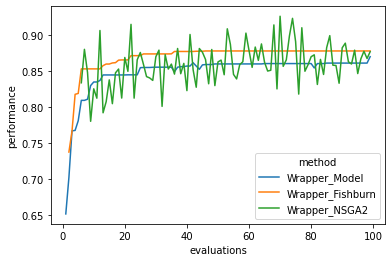

In [55]:
sns.lineplot(data=df2, x= "evaluations", y="performance", hue="method")

On remarque que juste avec cette idée basique on arrive a faire mieux qu'un algorithme aléatoire et a atteindre des performance comparable en moyenne a celle de NSGA3 en plus stable.